## Create ARIMA time series forecasting model based on the calendar features and generated features. </tab>
### Define the best paramaters and create 30 days autoregressive prediction

In [1]:
import numpy as np
from darts import TimeSeries
from darts.models import ARIMA
from darts.metrics import mse
from itertools import product
from typing import Dict, List, Tuple
from darts.dataprocessing.transformers import Scaler
from darts.utils.missing_values import fill_missing_values
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Create features
def calculate_rsi(prices, window=14):
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

def calculate_macd(prices, fast=12, slow=26, signal=9):
    exp1 = prices.ewm(span=fast, adjust=False).mean()
    exp2 = prices.ewm(span=slow, adjust=False).mean()
    macd = exp1 - exp2
    signal = macd.ewm(span=signal, adjust=False).mean()
    return macd - signal

def create_historical_features(series: pd.DataFrame, price_col: str = 'Close') -> pd.DataFrame:
    """
    Create historical price-based features.
    
    Args:
        series (pd.DataFrame): Input DataFrame with price data.
        price_col (str): Name of the column containing price data.
    
    Returns:
        pd.DataFrame: DataFrame with historical features.
    """
    df = series[[price_col]].copy()
    df['SMA_5'] = df[price_col].rolling(window=5).mean().shift(1)
    df['SMA_20'] = df[price_col].rolling(window=20).mean().shift(1)
    df['RSI'] = calculate_rsi(df[price_col]).shift(1)
    df['MACD'] = calculate_macd(df[price_col]).shift(1)
    df['Returns'] = df[price_col].pct_change().shift(1)
    df['Volatility'] = df['Returns'].rolling(window=20).std().shift(1)
    df.drop(columns=price_col, inplace=True)
    df.bfill(inplace=True)
    return df

def create_future_features(df: pd.DataFrame, price_col: str = 'Close') -> pd.DataFrame:
    """
    Create future price-based features for the next trading day.
    
    Args:
        df (pd.DataFrame): Input DataFrame with historical price data.
        price_col (str): Name of the column containing price data.
    
    Returns:
        pd.DataFrame: DataFrame with future features for the next trading day.
    """
    def is_weekend(timestamp):
        return timestamp.dayofweek >= 5
    
    next_date = df.index[-1] + pd.Timedelta(days=1)
    if is_weekend(next_date):
        next_date += pd.Timedelta(days=2)
    
    features = pd.DataFrame(index=[next_date])
    features['SMA_5'] = df[price_col].rolling(window=5).mean().iloc[-1]
    features['SMA_20'] = df[price_col].rolling(window=20).mean().iloc[-1]
    features['RSI'] = calculate_rsi(df[price_col]).iloc[-1]
    features['MACD'] = calculate_macd(df[price_col]).iloc[-1]
    
    df['Returns'] = df[price_col].pct_change()
    features['Returns'] = df['Returns'].iloc[-1]
    features['Volatility'] = df['Returns'].rolling(window=20).std().iloc[-1]
    return features

def create_static_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Create static time-based features.
    
    Args:
        df (pd.DataFrame): Input DataFrame with datetime index.
    
    Returns:
        pd.DataFrame: DataFrame with static time-based features.
    """
    static = pd.DataFrame(index=df.index)
    static['DayOfWeek'] = df.index.dayofweek
    static['Month'] = df.index.month
    static['Quarter'] = df.index.quarter
    static['Year'] = df.index.year
    return static

#Define best model

def create_train_val_splits(series: TimeSeries, static_covariates: TimeSeries, historical_covariates: TimeSeries, n_splits: int, val_length: int) -> List[Tuple[TimeSeries, TimeSeries, TimeSeries, TimeSeries, TimeSeries, TimeSeries]]:
    splits = []
    total_length = len(series)
    step = (total_length - val_length) // n_splits

    for i in range(n_splits):
        train_end = total_length - val_length - (n_splits - i - 1) * step
        val_start = train_end
        val_end = val_start + val_length

        train = series[:train_end]
        val = series[val_start:val_end]

        train_static_cov = static_covariates[:train_end]
        val_static_cov = static_covariates[val_start:val_end]

        train_hist_cov = historical_covariates[:train_end]
        val_hist_cov = historical_covariates[val_start:val_end]

        splits.append((train, val, train_static_cov, val_static_cov, train_hist_cov, val_hist_cov))

    return splits

def evaluate_model(model, splits: List[Tuple[TimeSeries, TimeSeries, TimeSeries, TimeSeries, TimeSeries, TimeSeries]]) -> float:
    mse_scores = []
    for train, val, train_static_cov, val_static_cov, train_hist_cov, val_hist_cov in splits:
        try:
            # Combine static and historical covariates
            train_covariates = train_static_cov.concatenate(train_hist_cov, axis=1)
            val_covariates = val_static_cov.concatenate(val_hist_cov, axis=1)

            model.fit(train, future_covariates=train_covariates)
            prediction = model.predict(len(val), future_covariates=val_covariates)
            mse_scores.append(mse(val, prediction))
        except Exception as e:
            print(f"Error in model evaluation: {str(e)}")
            return float('inf')  # Return a high MSE to discourage this parameter set

    return np.mean(mse_scores) if mse_scores else float('inf')

def hyperparameter_tuning(series: TimeSeries, static_covariates: TimeSeries, historical_covariates: TimeSeries, n_splits: int, val_length: int) -> Dict:
    # Define the hyperparameter search space
    p_values = range(0, 3)  # AR parameter
    d_values = range(0, 2)  # Differencing
    q_values = range(0, 3)  # MA parameter
    param_grid = list(product(p_values, d_values, q_values))

    splits = create_train_val_splits(series, static_covariates, historical_covariates, n_splits, val_length)

    best_mse = float('inf')
    best_params = None

    # Perform grid search
    for p, d, q in param_grid:
        model = ARIMA(p=p, d=d, q=q)
        try:
            current_mse = evaluate_model(model, splits)
            if current_mse < best_mse:
                best_mse = current_mse
                best_params = {'p': p, 'd': d, 'q': q}
            print(f"Parameters (p={p}, d={d}, q={q}) - MSE: {current_mse}")
        except Exception as e:
            print(f"Error with parameters (p={p}, d={d}, q={q}): {str(e)}")
            continue

    print(f'Best MSE: {best_mse}')
    return best_params

def find_best_arima_params(series: TimeSeries, static_covariates: TimeSeries, historical_covariates: TimeSeries, n_splits: int = 3, val_length: int = 30) -> Dict:
    """
    Find the best ARIMA parameters using time series cross-validation.

    Args:
    series (TimeSeries): The target time series (stock prices)
    static_covariates (TimeSeries): Static covariates (e.g., day of week, month)
    historical_covariates (TimeSeries): Historical covariates (e.g., SMA, RSI)
    n_splits (int): Number of splits for time series cross-validation
    val_length (int): Length of each validation set

    Returns:
    Dict: Best ARIMA parameters (p, d, q)
    """
    print("Starting ARIMA hyperparameter tuning...")
    best_params = hyperparameter_tuning(series, static_covariates, historical_covariates, n_splits, val_length)
    print(f"Best ARIMA parameters found: {best_params}")
    return best_params



Example of time series:  
 component        Close
Date                  
2024-06-11  170.660004
2024-06-12  177.289993
2024-06-13  182.470001
2024-06-14  178.009995
2024-06-17  187.440002

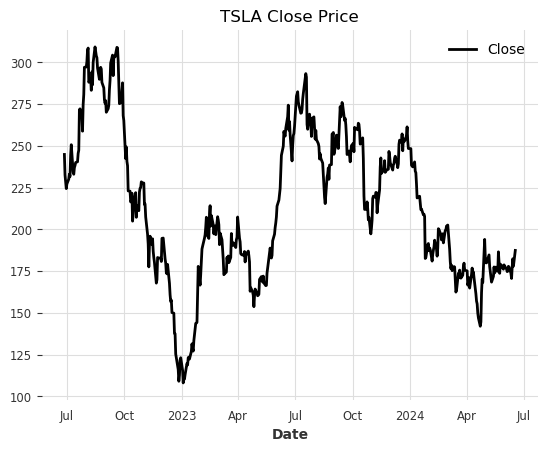

Example of historical features:  
                  SMA_5      SMA_20        RSI      MACD   Returns  Volatility
2024-06-11  175.795999  176.772501  48.765954 -0.490156 -0.020791    0.024593
2024-06-12  174.973999  176.711001  29.287928 -0.792165 -0.018010    0.024614
2024-06-13  175.431998  176.698000  46.349029 -0.524972  0.038849    0.024592
2024-06-14  176.337997  177.122000  61.661770 -0.006358  0.029218    0.025042
2024-06-17  176.443997  177.280500  48.309959  0.027466 -0.024442    0.025364
Example of static features:  
             DayOfWeek  Month  Quarter  Year
Date                                       
2024-06-11          1      6        2  2024
2024-06-12          2      6        2  2024
2024-06-13          3      6        2  2024
2024-06-14          4      6        2  2024
2024-06-17          0      6        2  2024
Starting ARIMA hyperparameter tuning...
Parameters (p=0, d=0, q=0) - MSE: 0.00216298070950555
Parameters (p=0, d=0, q=1) - MSE: 0.002487510194468359
Parameter

ARIMA(p=2, d=0, q=1, seasonal_order=(0, 0, 0, 0), trend=None, random_state=None, add_encoders=None)

In [8]:
file_path = '../data/TSLA.csv'
series = pd.read_csv(file_path, index_col='Unnamed: 0')
series.index = pd.to_datetime(series.index)
series = series[['Close']]
# Create Darts TimeSeries object
series['Date'] = series.index
ts_series = TimeSeries.from_dataframe(series, time_col='Date', value_cols=['Close'], fill_missing_dates=True, freq='B')
ts_series=fill_missing_values(ts_series)
print('Example of time series:  \n', ts_series.pd_dataframe().tail())
ts_series.plot()
plt.title('TSLA Close Price')
plt.show()

ts_scaler = Scaler()
ts_series_scaled = ts_scaler.fit_transform(ts_series)

# Create historical features
historical_features = create_historical_features(series, price_col='Close')
print('Example of historical features:  \n', historical_features.tail())
# Create static features
static_features = create_static_features(ts_series.pd_dataframe())
print('Example of static features:  \n', static_features.tail())

# Scale features/covariates
scaler_historical_features = Scaler()
historical_features_scaled = scaler_historical_features.fit_transform(
    TimeSeries.from_dataframe(historical_features, fill_missing_dates=True, freq='B')
)
historical_features_scaled=fill_missing_values(historical_features_scaled)

scaler_static_features = Scaler()
historical_static_scaled = scaler_static_features.fit_transform(
    TimeSeries.from_dataframe(static_features, fill_missing_dates=True, freq='B')
)

best_params = find_best_arima_params(ts_series_scaled, historical_static_scaled, historical_features_scaled)

print(f"Best ARIMA parameters: p={best_params['p']}, d={best_params['d']}, q={best_params['q']}")

# Now you can use these best parameters to train your final ARIMA model
final_model = ARIMA(p=best_params['p'], d=best_params['d'], q=best_params['q'])
all_covariates = historical_static_scaled.concatenate(historical_features_scaled, axis=1)
final_model.fit(ts_series_scaled, future_covariates=all_covariates)

# The final_model is now ready for making predictions

### Train model 

In [122]:
#Train and test model
start_test='2024-05-14'
train_series = series.loc[:start_test]#series[:train_length]
test_series = series.loc[start_test:]#series[train_length:]

#print test_series length
print('Test series length:', len(test_series))

train_series = TimeSeries.from_dataframe(train_series,  fill_missing_dates=True, freq='B')
train_series=fill_missing_values(train_series)
ts_scaler = Scaler()
train_series_scaled = ts_scaler.fit_transform(train_series)

# Create historical features
scaler_historical_features = Scaler()
historical_features_train = create_historical_features(train_series.pd_dataframe(), price_col='Close')
historical_features_train = TimeSeries.from_dataframe(historical_features_train, fill_missing_dates=True, freq='B')
historical_features_train_scaled = scaler_historical_features.fit_transform(historical_features_train)

# Create static features
static_features_train = create_static_features(train_series.pd_dataframe())
static_features_train = TimeSeries.from_dataframe(static_features_train, fill_missing_dates=True, freq='B')
static_features_train_scaled = scaler_static_features.transform(static_features_train)

# Combine static and historical covariates
train_covariates = static_features_train_scaled.concatenate(historical_features_train_scaled, axis=1)

#fit model with best params
model = ARIMA(**best_params)
model.fit(train_series_scaled, future_covariates=train_covariates)

# Create future features for the next trading day
future_features = create_future_features(train_series.pd_dataframe(), price_col='Close')
future_features = TimeSeries.from_dataframe(future_features, fill_missing_dates=True, freq='B')
future_features_scaled = scaler_historical_features.transform(future_features)

#Create static features for the next trading day
next_date = train_series.pd_dataframe().index[-1] + pd.Timedelta(days=1)
next_date = pd.DataFrame(index=[next_date])
next_static_features = create_static_features(next_date)
next_static_features = TimeSeries.from_dataframe(next_static_features, fill_missing_dates=True, freq='B')
next_static_features_scaled = scaler_static_features.transform(next_static_features)

# Combine static and historical covariates
future_covariates = next_static_features_scaled.concatenate(future_features_scaled, axis=1)
# Make predictions for the each next trading day in train_series
train_predictions = []

for i in range(len(test_series)):
    prediction = model.predict((i+1), future_covariates=future_covariates)

    # Inverse transform the prediction
    prediction = ts_scaler.inverse_transform(prediction)

    #Add the prediction to the list
    train_predictions.append(prediction)
    #print(prediction)
    #Add the prediction to the training series
    train_series = train_series.append(prediction.tail(1))

    # Update the future covariates for the next trading day
    future_features = create_future_features(train_series.pd_dataframe(), price_col='Close')
    future_features = TimeSeries.from_dataframe(future_features, fill_missing_dates=True, freq='B')
    future_features_scaled = scaler_historical_features.transform(future_features)

    next_date = train_series.pd_dataframe().index[-1] + pd.Timedelta(days=1)
    def is_weekend(timestamp):
            return timestamp.dayofweek >= 5
    if is_weekend(next_date):
        next_date += pd.Timedelta(days=2)
    next_date = pd.DataFrame(index=[next_date])
    next_static_features = create_static_features(next_date)
    next_static_features = TimeSeries.from_dataframe(next_static_features, fill_missing_dates=True, freq='B')
    next_static_features_scaled = scaler_static_features.transform(next_static_features)

    future_covariates_scaled_new = next_static_features_scaled.concatenate(future_features_scaled, axis=1)
    future_covariates = future_covariates.append(future_covariates_scaled_new)
    #future_covariates = next_static_features_scaled.concatenate(future_features_scaled, axis=1)




Test series length: 24


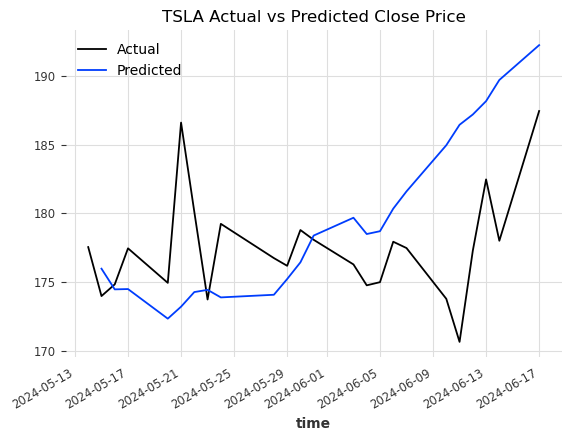

Mean Absolute Percentage Error (MAPE): 2.83%


In [120]:
from matplotlib import pyplot as plt
test_data=pd.DataFrame(test_series)
test_data.rename(columns={'Close':'Actual'}, inplace=True)
test_data['Predicted']=prediction.pd_dataframe()
test_data.plot()
plt.title('TSLA Actual vs Predicted Close Price')
plt.show()
mape = np.mean(np.abs((test_data['Actual'] - test_data['Predicted']) / test_data['Actual'])) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

### Use the model to make predictions for 30 days

In [3]:
# Create future features
future_historical_features = create_future_features(series, price_col='Close')
next_date = series.index[-1] + pd.Timedelta(days=1)
future_static_features = create_static_features(pd.DataFrame(index=[next_date]))

# Scale features/covariates
future_historical_features_scaled = scaler_historical_features.transform(
    TimeSeries.from_dataframe(future_historical_features, fill_missing_dates=True, freq='B')
)

future_static_features_scaled = scaler_static_features.transform(
    TimeSeries.from_dataframe(future_static_features, fill_missing_dates=True, freq='B')
)

# Concatenate features
historical_covariates_scaled = historical_static_scaled.concatenate(historical_features_scaled, axis=1)
historical_covariates_scaled = fill_missing_values(historical_covariates_scaled)
future_covariates_scaled = future_static_features_scaled.concatenate(future_historical_features_scaled, axis=1)

# Create Darts TimeSeries object
#series['Date'] = series.index
#ts_series = TimeSeries.from_dataframe(series, time_col='Date', value_cols=['Close'], fill_missing_dates=True, freq='B')
#ts_scaler = Scaler()
#ts_series_scaled = ts_scaler.fit_transform(ts_series)

# Train ARIMA model
model = ARIMA(**best_params)
model.fit(ts_series_scaled, future_covariates=historical_covariates_scaled)

ARIMA(p=2, d=0, q=1, seasonal_order=(0, 0, 0, 0), trend=None, random_state=None, add_encoders=None)

In [4]:
#Use the model to make predictions for 30 days
series_=series.copy()
future_covariates_scaled_all=future_covariates_scaled.copy()
predictions=[]
for step in range(30):
        #print(f"\nStep {step}:")
        # Make a forecast  based on defined covariantes
        pred=model.predict((step+1), future_covariates=future_covariates_scaled_all)    
        #print(pred)
        pred = ts_scaler.inverse_transform(pred)
        predicted_value = pred.pd_dataframe()['Close'].iloc[-1]
        predictions.append(predicted_value)
        series_.loc[pred.pd_dataframe().index[-1], 'Close'] = predicted_value
        #Calculate features for the next day
        next_date = series_.index[-1] + pd.Timedelta(days=1)
        
        #check if the next day is a weekend
        def is_weekend(timestamp):
            return timestamp.dayofweek >= 5
        #skip weekends
        if is_weekend(next_date):
            next_date += pd.Timedelta(days=2)
        #1. New static features
        future_static_features = create_static_features(pd.DataFrame(index=[next_date]))
        future_static_features_scaled = scaler_static_features.transform(TimeSeries.from_dataframe(future_static_features,
                                                                                       fill_missing_dates=True, freq='B'))
        #2. New historical features
        future_historical_features = create_future_features(series_, price_col='Close')
        future_historical_features_scaled = scaler_historical_features.transform(TimeSeries.from_dataframe(future_historical_features, 
                                                                                                           fill_missing_dates=True, freq='B'))
        #3. Combine static and historical features
        future_covariates_scaled_new = future_static_features_scaled.concatenate(future_historical_features_scaled, axis=1)
        future_covariates_scaled_all = future_covariates_scaled_all.append(future_covariates_scaled_new)
        

### Plot predictions

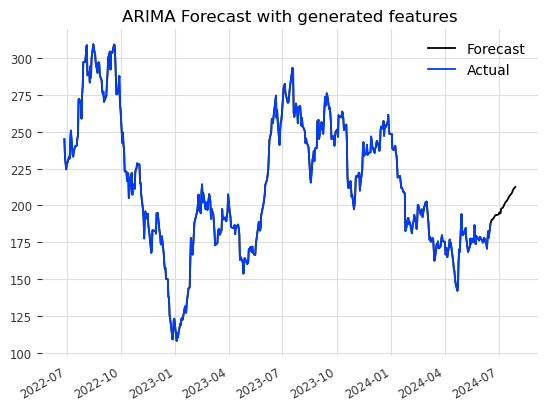

In [6]:
from matplotlib import pyplot as plt
series_['Close'].plot(label='Forecast')
series.Close.plot(label='Actual')
plt.legend()
plt.title('ARIMA Forecast with generated features')
plt.show()


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from darts import TimeSeries
from darts.models import ARIMA
from darts.metrics import mse
from darts.dataprocessing.transformers import Scaler
from darts.utils.missing_values import fill_missing_values
from itertools import product
from typing import Dict, List, Tuple
import warnings

warnings.filterwarnings('ignore')

# Feature Engineering Functions

def calculate_rsi(prices, window=14):
    """Calculate Relative Strength Index (RSI)."""
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

def calculate_macd(prices, fast=12, slow=26, signal=9):
    """Calculate Moving Average Convergence Divergence (MACD)."""
    exp1 = prices.ewm(span=fast, adjust=False).mean()
    exp2 = prices.ewm(span=slow, adjust=False).mean()
    macd = exp1 - exp2
    signal = macd.ewm(span=signal, adjust=False).mean()
    return macd - signal

def create_historical_features(series: pd.DataFrame, price_col: str = 'Close') -> pd.DataFrame:
    """Create historical price-based features."""
    df = series[[price_col]].copy()
    df['SMA_5'] = df[price_col].rolling(window=5).mean().shift(1)
    df['SMA_20'] = df[price_col].rolling(window=20).mean().shift(1)
    df['RSI'] = calculate_rsi(df[price_col]).shift(1)
    df['MACD'] = calculate_macd(df[price_col]).shift(1)
    df['Returns'] = df[price_col].pct_change().shift(1)
    df['Volatility'] = df['Returns'].rolling(window=20).std().shift(1)
    df.drop(columns=price_col, inplace=True)
    df.bfill(inplace=True)
    return df

def create_future_features(df: pd.DataFrame, price_col: str = 'Close') -> pd.DataFrame:
    """Create future price-based features for the next trading day."""
    def is_weekend(timestamp):
        return timestamp.dayofweek >= 5
    
    next_date = df.index[-1] + pd.Timedelta(days=1)
    if is_weekend(next_date):
        next_date += pd.Timedelta(days=2)
    
    features = pd.DataFrame(index=[next_date])
    features['SMA_5'] = df[price_col].rolling(window=5).mean().iloc[-1]
    features['SMA_20'] = df[price_col].rolling(window=20).mean().iloc[-1]
    features['RSI'] = calculate_rsi(df[price_col]).iloc[-1]
    features['MACD'] = calculate_macd(df[price_col]).iloc[-1]
    
    df['Returns'] = df[price_col].pct_change()
    features['Returns'] = df['Returns'].iloc[-1]
    features['Volatility'] = df['Returns'].rolling(window=20).std().iloc[-1]
    return features

def create_static_features(df: pd.DataFrame) -> pd.DataFrame:
    """Create static time-based features."""
    static = pd.DataFrame(index=df.index)
    static['DayOfWeek'] = df.index.dayofweek
    static['Month'] = df.index.month
    static['Quarter'] = df.index.quarter
    static['Year'] = df.index.year
    return static

# Model Training and Evaluation Functions

def create_train_val_splits(series: TimeSeries, static_covariates: TimeSeries, historical_covariates: TimeSeries, n_splits: int, val_length: int) -> List[Tuple[TimeSeries, TimeSeries, TimeSeries, TimeSeries, TimeSeries, TimeSeries]]:
    """Create train-validation splits for time series cross-validation."""
    splits = []
    total_length = len(series)
    step = (total_length - val_length) // n_splits

    for i in range(n_splits):
        train_end = total_length - val_length - (n_splits - i - 1) * step
        val_start = train_end
        val_end = val_start + val_length

        train = series[:train_end]
        val = series[val_start:val_end]

        train_static_cov = static_covariates[:train_end]
        val_static_cov = static_covariates[val_start:val_end]

        train_hist_cov = historical_covariates[:train_end]
        val_hist_cov = historical_covariates[val_start:val_end]

        splits.append((train, val, train_static_cov, val_static_cov, train_hist_cov, val_hist_cov))

    return splits

def evaluate_model(model, splits: List[Tuple[TimeSeries, TimeSeries, TimeSeries, TimeSeries, TimeSeries, TimeSeries]]) -> float:
    """Evaluate the model using time series cross-validation."""
    mse_scores = []
    for train, val, train_static_cov, val_static_cov, train_hist_cov, val_hist_cov in splits:
        try:
            train_covariates = train_static_cov.concatenate(train_hist_cov, axis=1)
            val_covariates = val_static_cov.concatenate(val_hist_cov, axis=1)

            model.fit(train, future_covariates=train_covariates)
            prediction = model.predict(len(val), future_covariates=val_covariates)
            mse_scores.append(mse(val, prediction))
        except Exception as e:
            print(f"Error in model evaluation: {str(e)}")
            return float('inf')

    return np.mean(mse_scores) if mse_scores else float('inf')

def hyperparameter_tuning(series: TimeSeries, static_covariates: TimeSeries, historical_covariates: TimeSeries, n_splits: int, val_length: int) -> Dict:
    """Perform hyperparameter tuning for ARIMA model."""
    p_values = range(0, 3)
    d_values = range(0, 2)
    q_values = range(0, 3)
    param_grid = list(product(p_values, d_values, q_values))

    splits = create_train_val_splits(series, static_covariates, historical_covariates, n_splits, val_length)

    best_mse = float('inf')
    best_params = None

    for p, d, q in param_grid:
        model = ARIMA(p=p, d=d, q=q)
        try:
            current_mse = evaluate_model(model, splits)
            if current_mse < best_mse:
                best_mse = current_mse
                best_params = {'p': p, 'd': d, 'q': q}
            print(f"Parameters (p={p}, d={d}, q={q}) - MSE: {current_mse}")
        except Exception as e:
            print(f"Error with parameters (p={p}, d={d}, q={q}): {str(e)}")
            continue

    print(f'Best MSE: {best_mse}')
    return best_params

def find_best_arima_params(series: TimeSeries, static_covariates: TimeSeries, historical_covariates: TimeSeries, n_splits: int = 3, val_length: int = 30) -> Dict:
    """Find the best ARIMA parameters using time series cross-validation."""
    print("Starting ARIMA hyperparameter tuning...")
    best_params = hyperparameter_tuning(series, static_covariates, historical_covariates, n_splits, val_length)
    print(f"Best ARIMA parameters found: {best_params}")
    return best_params



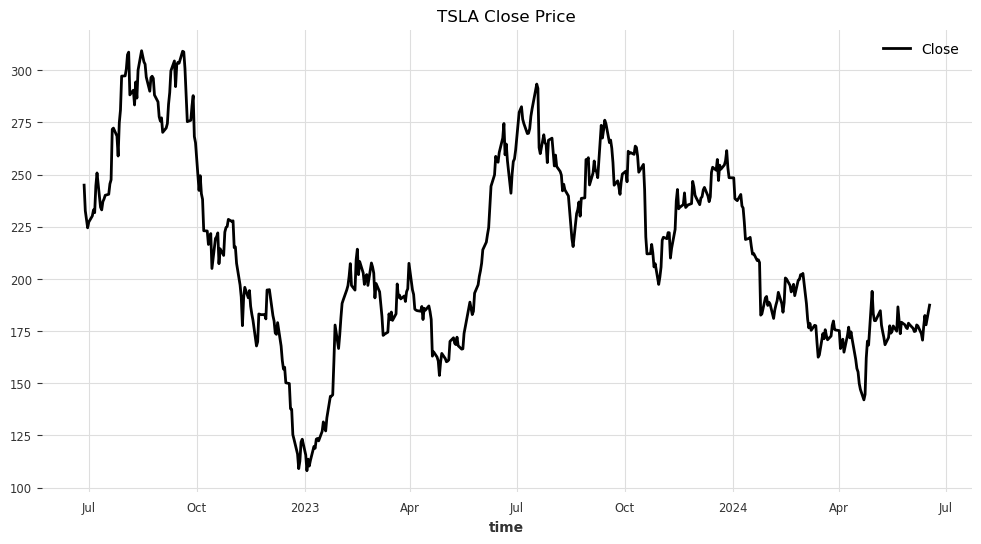

Starting ARIMA hyperparameter tuning...
Parameters (p=0, d=0, q=0) - MSE: 0.00216298070950555
Parameters (p=0, d=0, q=1) - MSE: 0.002487510194468359
Parameters (p=0, d=0, q=2) - MSE: 0.0023420108987911
Parameters (p=0, d=1, q=0) - MSE: 0.008037076718463647
Parameters (p=0, d=1, q=1) - MSE: 0.00880456828337118
Parameters (p=0, d=1, q=2) - MSE: 0.011725804649630675
Parameters (p=1, d=0, q=0) - MSE: 0.0022872200665445784
Parameters (p=1, d=0, q=1) - MSE: 0.002198062755914119
Parameters (p=1, d=0, q=2) - MSE: 0.002204051797742295
Parameters (p=1, d=1, q=0) - MSE: 0.00881460919516277
Parameters (p=1, d=1, q=1) - MSE: 0.009172284327416217
Parameters (p=1, d=1, q=2) - MSE: 0.011391062318636834
Parameters (p=2, d=0, q=0) - MSE: 0.002565697866961585
Parameters (p=2, d=0, q=1) - MSE: 0.002145719627301802
Parameters (p=2, d=0, q=2) - MSE: 0.0022010885494858756
Parameters (p=2, d=1, q=0) - MSE: 0.019196333318483045
Parameters (p=2, d=1, q=1) - MSE: 0.022075488995370995
Parameters (p=2, d=1, q=2) -

ValueError: For the given forecasting horizon `n=1`, the provided `future_covariates` series must contain at least the next `n=1` time steps/indices after the end of the target `series` that was used to train the model.


ValueError: For the given forecasting horizon `n=1`, the provided `future_covariates` series must contain at least the next `n=1` time steps/indices after the end of the target `series` that was used to train the model.

In [15]:
# Main Execution


# Load and preprocess data
file_path = '../data/TSLA.csv'
series = pd.read_csv(file_path, index_col='Unnamed: 0')
series.index = pd.to_datetime(series.index)
series = series[['Close']]

# Create Darts TimeSeries object
ts_series = TimeSeries.from_dataframe(series, fill_missing_dates=True, freq='B')
ts_series = fill_missing_values(ts_series)

# Plot original time series
plt.figure(figsize=(12, 6))
ts_series.plot()
plt.title('TSLA Close Price')
plt.show()

# Scale time series
ts_scaler = Scaler()
ts_series_scaled = ts_scaler.fit_transform(ts_series)

# Create and scale features
historical_features = create_historical_features(series, price_col='Close')
static_features = create_static_features(ts_series.pd_dataframe())

scaler_historical_features = Scaler()
historical_features_scaled = scaler_historical_features.fit_transform(
TimeSeries.from_dataframe(historical_features, fill_missing_dates=True, freq='B')
)
historical_features_scaled = fill_missing_values(historical_features_scaled)

scaler_static_features = Scaler()
historical_static_scaled = scaler_static_features.fit_transform(
TimeSeries.from_dataframe(static_features, fill_missing_dates=True, freq='B')
)

# Find best ARIMA parameters
best_params = find_best_arima_params(ts_series_scaled, historical_static_scaled, historical_features_scaled)
print(f"Best ARIMA parameters: p={best_params['p']}, d={best_params['d']}, q={best_params['q']}")

# Train final model
final_model = ARIMA(p=best_params['p'], d=best_params['d'], q=best_params['q'])
all_covariates = historical_static_scaled.concatenate(historical_features_scaled, axis=1)
final_model.fit(ts_series_scaled, future_covariates=all_covariates)

# Make predictions
future_horizon = 30
predictions = []
series_ = series.copy()
#future_covariates_scaled_all = historical_static_scaled.concatenate(historical_features_scaled, axis=1)
#future_covariates_scaled_all = all_covariates.slice_intersect(all_covariates.end_time(), all_covariates.end_time())
last_date = all_covariates.end_time()
future_covariates_scaled_all = all_covariates.slice(last_date, last_date)

for step in range(future_horizon):
    pred = final_model.predict(1, future_covariates=future_covariates_scaled_all)
    pred = ts_scaler.inverse_transform(pred)
    predicted_value = pred.pd_dataframe()['Close'].iloc[-1]
    predictions.append(predicted_value)

    next_date = series_.index[-1] + pd.Timedelta(days=1)
    if next_date.dayofweek >= 5:
        next_date += pd.Timedelta(days=2)

    series_.loc[next_date, 'Close'] = predicted_value

    future_static_features = create_static_features(pd.DataFrame(index=[next_date]))
    future_static_features_scaled = scaler_static_features.transform(
    TimeSeries.from_dataframe(future_static_features, fill_missing_dates=True, freq='B')
    )

    future_historical_features = create_future_features(series_, price_col='Close')
    future_historical_features_scaled = scaler_historical_features.transform(
    TimeSeries.from_dataframe(future_historical_features, fill_missing_dates=True, freq='B')
    )

    future_covariates_scaled_new = future_static_features_scaled.concatenate(future_historical_features_scaled, axis=1)
    future_covariates_scaled_all = future_covariates_scaled_all.append(future_covariates_scaled_new)

# Plot results
plt.figure(figsize=(12, 6))
series_['Close'].plot(label='Forecast')
series.Close.plot(label='Actual')
plt.legend()
plt.title('ARIMA Forecast with Generated Features')
plt.show()

# Calculate and print forecast accuracy
actual_values = series.Close[-future_horizon:]
forecast_values = series_['Close'][-future_horizon:]
mape = np.mean(np.abs((actual_values - forecast_values) / actual_values)) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")


In [13]:
last_date = all_covariates.end_time()
future_covariates_scaled_all = all_covariates.slice(last_date, last_date)

In [14]:
future_covariates_scaled_all.pd_dataframe()

component,DayOfWeek,Month,Quarter,Year,SMA_5,SMA_20,RSI,MACD,Returns,Volatility
time,,,,,,,,,,
2024-06-17,0.0,0.454545,0.333333,1.0,0.329638,0.317314,0.456797,0.47669,0.355655,0.193292
